In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import matrix_normalization, convert_states_str2int, \
    normalize_state, normalize_weights, get_null_p, get_fdr_p
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Wrapping Pathway A for ease of use

### Load A

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy/results'
A_file = 'pnc_schaefer200_Am.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


### Get states

In [4]:
# load node-to-system mapping
system_labels = list(np.loadtxt(os.path.join(datadir, 'pnc_schaefer200_system_labels.txt'),
                                dtype=str))

In [5]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [6]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

### Setup control tasks

In [7]:
# initialize list of control tasks
control_tasks = []

# define control nodes using a uniform full control set
# note, here we use the same control nodes for all control tasks
B = np.eye(n_nodes)

# define state trajectory constraint nodes.
# note, here we constrain the full state trajectory equally for all control tasks
S = np.eye(n_nodes)

# define mixing parameter
rho = 1

# assemble control tasks
n_states = len(state_labels)
for i in np.arange(n_states):
    x0 = states == i  # set initial state to ith state
    x0 = normalize_state(x0)  # normalize state magnitude
    for j in np.arange(n_states):
        xf = states == j  # set target state to jth state
        xf = normalize_state(xf)  # normalize state magnitude

        control_task = dict()  # initialize dict
        control_task['x0'] = x0  # store initial state
        control_task['xf'] = xf  # store target state
        control_task['B'] = B  # store control nodes
        control_task['S'] = S  # store state trajectory constraints
        control_task['rho'] = rho  # store rho
        control_tasks.append(control_task)

### Run ComputeControlEnergy

In [8]:
# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(A=A,
                                              control_tasks=control_tasks,
                                              system='continuous',
                                              c=1,
                                              T=1)
compute_control_energy.run()

100%|██████████| 49/49 [00:02<00:00, 23.58it/s]


### Plot energy matrices

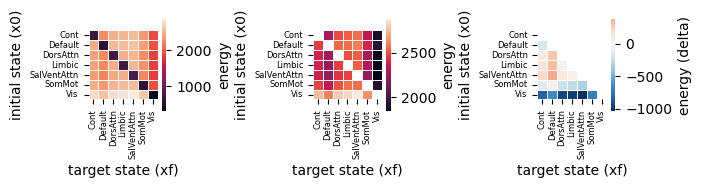

In [9]:
# reshape energy into matrix
E = np.reshape(compute_control_energy.E, (n_states, n_states))

# subtract lower triangle from upper to examine energy asymmetries
Ed = E.transpose() - E

f, ax = plt.subplots(1, 3, figsize=(7, 4))

# plot energy matrix
sns.heatmap(E, ax=ax[0], square=True, linewidth=0.5, cbar_kws={'label': 'energy', "shrink": 0.25})

# plot without self-transitions
# setup mask to exclude persistence energy (i.e., transitions where i==j)
mask = np.zeros_like(E)
mask[np.eye(n_states) == 1] = True
sns.heatmap(E, ax=ax[1], square=True, linewidth=0.5, cbar_kws={'label': 'energy', "shrink": 0.25},
            mask=mask)

# plot energy asymmetries
mask = np.triu(np.ones_like(E, dtype=bool))
sns.heatmap(Ed, ax=ax[2], square=True, linewidth=0.5, cbar_kws={'label': 'energy (delta)', "shrink": 0.25},
            mask=mask, cmap='RdBu_r', center=0)

for cax in ax:
    cax.set_ylabel('initial state (x0)')
    cax.set_xlabel('target state (xf)')
    # cax.set_yticklabels(np.arange(1, n_states+1))
    # cax.set_xticklabels(np.arange(1, n_states+1))
    cax.set_yticklabels(state_labels, rotation=0, size=6)
    cax.set_xticklabels(state_labels, rotation=90, size=6)
f.tight_layout()
f.savefig(os.path.join(resultsdir, 'energy_matrix.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()